In [129]:
import math
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import pearsonr
from numpy import cov
# generate related variables
from numpy import mean
from numpy import std

In [130]:
%run RSA_model-helpers.ipynb

小明说张伟把ta自己的花瓶打坏了.
world1: xiaoming
world2: zhangwei

#### Rational Listener Interpretation
$P_L(w|m) \propto P(w) \times P_s(m|w)$ </br>
#### Speaker Probability (Likelihood)
$P_s(m|w) \propto exp(\alpha \times U_s(m,w))$
#### Speaker Utility
$U_s(m,w) = ln(P_{LL}(w|m))-Cost(m)$
#### Literal Listener (normalize)
For all $w ∈ W$ and $m ∈ M$,</br>
$P_{LL}(w|[m]) = \frac{P(\{w\}\bigcap  [[m]])}{P([[m]])}$
#### Prior probability for each world state
$P(w)$
#### Message Cost
$Cost(m) = -log(P(m))$

#### Rational Listener Interpretation
$P_L(r|u) \propto P(r) \times P_s(u|r)$ </br>
#### Speaker Probability (Likelihood)
$P_s(u|r) \propto exp(\alpha \times U_s(u,r))$
#### Speaker Utility
$U_s(u,r) = ln(P_{LL}(r|u))-Cost(u)$
#### Literal Listener (normalize)
For all $r$ and $u$,</br>
$P_{LL}(r|[u]) = \frac{P(\{r\}\bigcap  [[u]])}{P([[u]])}$
#### Prior probability for each world state
$P(r)$
#### Message Cost
$Cost(u) = -log(P(u))$

In [131]:
# Pairs = {'ziji': ['Speaker', 'Clause Subject'],'taziji': ['Clause Subject'],'ta': ['Speaker','Clause Subject', 'Others']}
# Pairs


In [132]:

W = ['Non-local NP', 'Local NP','Others']
M = ['ta', 'taziji', 'ziji']

In [119]:
data = pd.read_csv("final_data_bySenID.csv", index_col=[0])
data = data.drop('Freq', 1)

/var/folders/gd/crxq4l256sx5f_sx6kdf41tr0000gn/T/ipykernel_5621/588324218.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop('Freq', 1)


In [120]:
P_ziji = 309053/1046136
P_taziji = 1503/1046136
P_ta = 735580/1046136

Softmax = (normalize(getLikelihood(8, data, 0.93, P_ziji, P_taziji, P_ta)))
printLikelihood(Softmax)
P_W = getPrior(8, data)
RL = RationalListener_Normalized(P_W, Softmax)
printNormalizedRational(RL)

TypeError: cannot convert the series to <class 'float'>

In [121]:
# add others to the dataset because in the second experiment, I did not add that condition
others = {'senID':[i for i in range(1,31)],
        'experiment':['likelihood' for x in range(1,31)],
        'condition': ['Others' for x in range(1,31)],
        'selection':['ta' for x in range(1,31)],
        'Prob':[1 for x in range(1,31)]
       }
others = pd.DataFrame(others)
others['type'] = np.where(others['senID'] < 15, 'co-argument', 'possessor')
data = data.append(others, ignore_index = True) 

mapping = [ ('Speaker', 'Non-local NP'), ('Clause Subject', 'Local NP'), ('co-argument', 'coargument')]
for k, v in mapping:
    data = data.replace(k, v)

data


/var/folders/gd/crxq4l256sx5f_sx6kdf41tr0000gn/T/ipykernel_5621/3299482280.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(others, ignore_index = True)


,senID,experiment,type,condition,selection,Prob
0,1,likelihood,coargument,Local NP,ta,0.194444
1,1,likelihood,coargument,Local NP,taziji,0.555556
2,1,likelihood,coargument,Local NP,ziji,0.250000
3,1,likelihood,coargument,Non-local NP,ta,0.500000
4,1,likelihood,coargument,Non-local NP,taziji,0.107143
...,...,...,...,...,...,...
541,26,likelihood,possessor,Others,ta,1.000000
542,27,likelihood,possessor,Others,ta,1.000000
543,28,likelihood,possessor,Others,ta,1.000000
544,29,likelihood,possessor,Others,ta,1.000000


In [122]:
def estimateLikelihood(c1, c2, c3):
    '''
    c1(str): co-argument or possessor
    c2(str): speaker or clause subject or others
    c3(str): ta or ziji or taziji
    '''
    df = data[(data.type == c1) & ((data.condition == 'prior') & (data.selection == c2)) | ((data.condition == c2) & (data.selection == c3)) | ((data.condition == c3) & (data.selection == c2))]
    #print(df)
    df = df.pivot(index='senID', columns = 'experiment', values = "Prob")[['prior', 'likelihood']]
    estimated_likelihood = []
    for i in df.index.values:
        estimated_likelihood.append(normalize(getLikelihood(i, data, 0.93, P_ziji, P_taziji, P_ta))[c2][M.index(c3)])
    df['estimated_likelihood'] = estimated_likelihood
    
    df = df.dropna(subset = ['prior'])
    df = df.fillna(0)
    #display(df)
    
    
    x = df['likelihood']
    y = df['estimated_likelihood']
    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(x=x,y=y, c='DarkBlue')
    ax.set_title("Rational Listner: P ( {} | {} ) in {} condition".format(c2,c3,c1))
    ax.set_xlabel('observed likelihood') #x label
    ax.set_ylabel('predicted likelihood') #y label

    for i, row in df.iterrows():
        plt.annotate(i, (row['likelihood'], row['estimated_likelihood']))
        
    # Plot regression line
    b, a = np.polyfit(x, y, deg=1)
    ax.plot(x, a + b * x);

    plt.show()


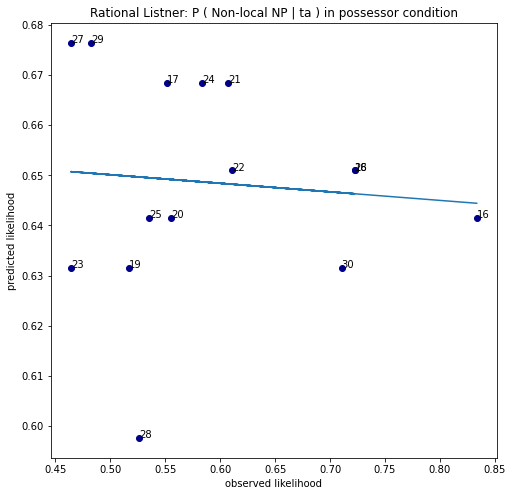

In [123]:
estimateLikelihood('possessor','Non-local NP','ta')

In [124]:
c1 = ['co-argument','possessor']
c2 = ['Speaker', 'Clause Subject']
c3 = ['ta', 'taziji', 'ziji']

for i in c1:
    if i == 'co-argument':
        P_ziji = 309053/1046136
        P_taziji = 1503/1046136
        P_ta = 735580/1046136
    else:
        P_ziji = 187517/263039
        P_taziji = 695/263039
        P_ta = 74827/263039
    for j in c2:
        for k in c3:
            estimateLikelihood(i,j,k)

KeyError: "None of [Index(['prior', 'likelihood'], dtype='object', name='experiment')] are in the [columns]"

In [133]:
def estimatePosterior(c1, c2, c3):
    '''
    c1(str): co-argument or possessor
    c2(str): speaker or clause subject or others
    c3(str): ta or ziji or taziji
    '''
    df = data[(data.type == c1) & ((data.condition == 'prior') & (data.selection == c2)) | ((data.condition == c2) & (data.selection == c3)) | ((data.condition == c3) & (data.selection == c2))]
    #print(df)
    df = df.pivot(index='senID', columns = 'experiment', values = "Prob")[['prior', 'likelihood','posterior']]
    estimated_Posterior = []
    estimated_likelihood = []
    for i in df.index.values:
        Softmax = normalize(getLikelihood(i, data, 0.93, P_ziji, P_taziji, P_ta))
        P_W = getPrior(i,data)
        #print(Softmax)
        RL = RationalListener_Normalized(P_W, Softmax)
        #printNormalizedRational(RL)
        estimated_likelihood.append(Softmax[c2][M.index(c3)])
        estimated_Posterior.append(RL[c3][W.index(c2)])
        
    df['estimated_likelihood'] = estimated_likelihood
    df['estimated_Posterior'] = estimated_Posterior
    
    df = df.dropna(subset = ['prior'])
    df = df.fillna(0)
    #display(df)
    
    
    x = df['posterior']
    y = df['estimated_Posterior']
    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(x=x,y=y, c='DarkBlue')
    ax.set_title("Listener Interpretation: P ( {} | {} ) in {} condition".format(c2,c3,c1))
    ax.set_xlabel('Expermental Data') #x label
    ax.set_ylabel('RSA Model Prediction') #y label
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
#     ax.plot(x, x, label = 'y=x');
    
    for i, row in df.iterrows():
        plt.annotate(i, (row['posterior'], row['estimated_Posterior']))
        

    # Plot regression line
    b, a = np.polyfit(x, y, deg=1)
    ax.plot(x, a + b * x, label = 'fitted line');
    
    plt.legend()
    #name = '{}_{}_{}.png'.format(c1,c2,c3)
    #print(name)
    #plt.savefig(name)
    #plt.show()
    
    
#     res = stats.linregress(x, y)
#     #cor.test
#     pval = res.pvalue
#     print("Statistics:", res)
#     print(f"R-squared: {res.rvalue**2:.6f}")

#     if pval<0.05:
#         print("pval = {}, reject null hypothesis".format(pval))
#     else:
#         print("pval = {}, accept null hypothesis".format(pval))
        
        
        
    #plt.savefig('RSA_{}_{}_{}.png'.format(c3, c1, c2))
    plt.show()
    
    # summarize
    print('x: mean=%.3f stdv=%.3f' % (mean(x), std(x)))
    print('y: mean=%.3f stdv=%.3f' % (mean(y), std(y)))
    
    res = stats.linregress(x, y)
    pval = res.pvalue
    print("Statistics:", res)
    print(f"R-squared: {res.rvalue**2:.6f}")
    
    corr, _ = pearsonr(x, y)
    print('Pearsons correlation: %.3f' % corr)
    
    covariance = cov(x, y)
    print("covariance is: ", covariance)

    if pval<0.05:
        print("pval = {}, reject null hypothesis".format(pval))
    else:
        print("pval = {}, accept null hypothesis".format(pval))


coargument ta Non-local NP


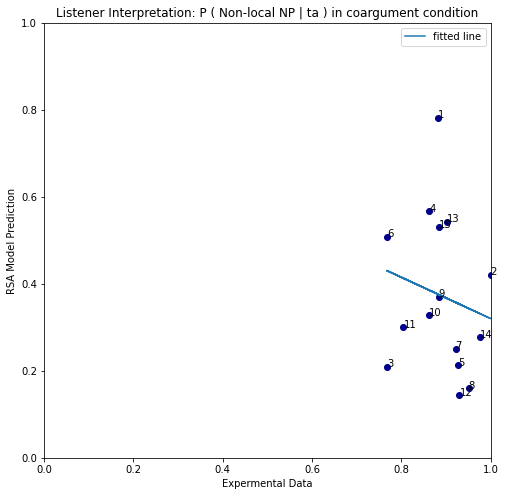

x: mean=0.888 stdv=0.066
y: mean=0.373 stdv=0.175
Statistics: LinregressResult(slope=-0.4746369892856643, intercept=0.7948195354138967, rvalue=-0.17988310124925996, pvalue=0.5211911763883716, stderr=0.7198746972862284, intercept_stderr=0.6411518644822822)
R-squared: 0.032358
Pearsons correlation: -0.180
covariance is:  [[ 0.00472505 -0.00224269]
 [-0.00224269  0.03289646]]
pval = 0.5211911763883716, accept null hypothesis
coargument ta Local NP


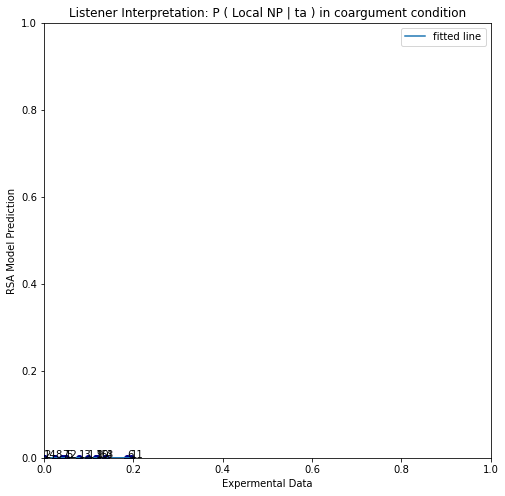

x: mean=0.090 stdv=0.060
y: mean=0.000 stdv=0.000
Statistics: LinregressResult(slope=0.0, intercept=0.0, rvalue=0.0, pvalue=1.0, stderr=0.0, intercept_stderr=0.0)
R-squared: 0.000000
Pearsons correlation: nan
covariance is:  [[0.00385553 0.        ]
 [0.         0.        ]]
pval = 1.0, accept null hypothesis
coargument ta Others


/Users/lisazhao/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


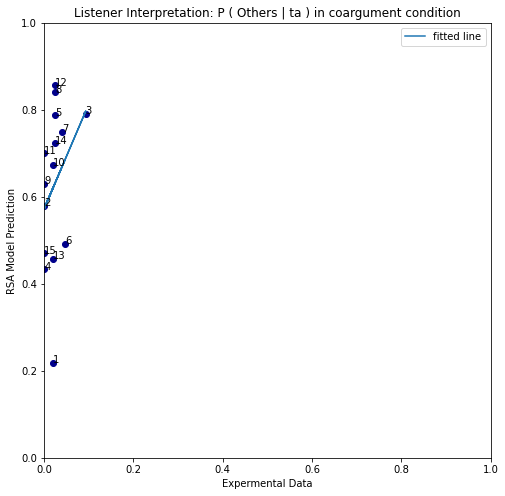

x: mean=0.022 stdv=0.024
y: mean=0.627 stdv=0.175
Statistics: LinregressResult(slope=2.408801734401483, intercept=0.5731000927459052, rvalue=0.325242244934729, pvalue=0.23685563511481347, stderr=1.942423873142614, intercept_stderr=0.06310818309986257)
R-squared: 0.105783
Pearsons correlation: 0.325
covariance is:  [[0.00059974 0.00144465]
 [0.00144465 0.03289646]]
pval = 0.23685563511481347, accept null hypothesis
coargument taziji Non-local NP


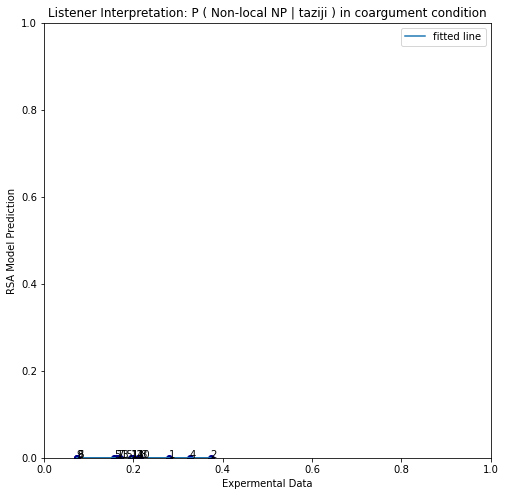

x: mean=0.191 stdv=0.084
y: mean=0.000 stdv=0.000
Statistics: LinregressResult(slope=0.0, intercept=0.0, rvalue=0.0, pvalue=1.0, stderr=0.0, intercept_stderr=0.0)
R-squared: 0.000000
Pearsons correlation: nan
covariance is:  [[0.0074757 0.       ]
 [0.        0.       ]]
pval = 1.0, accept null hypothesis
coargument taziji Local NP


/Users/lisazhao/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


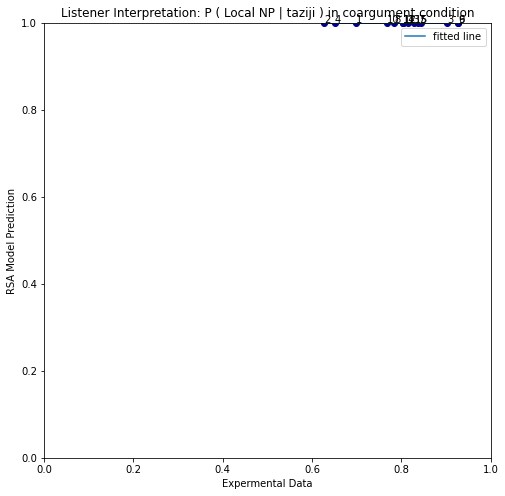

x: mean=0.801 stdv=0.086
y: mean=1.000 stdv=0.000
Statistics: LinregressResult(slope=0.0, intercept=1.0, rvalue=0.0, pvalue=1.0, stderr=0.0, intercept_stderr=0.0)
R-squared: 0.000000
Pearsons correlation: nan
covariance is:  [[0.00790648 0.        ]
 [0.         0.        ]]
pval = 1.0, accept null hypothesis
coargument taziji Others
[coargument,taziji,Others] combination does not exist
coargument ziji Non-local NP


/Users/lisazhao/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


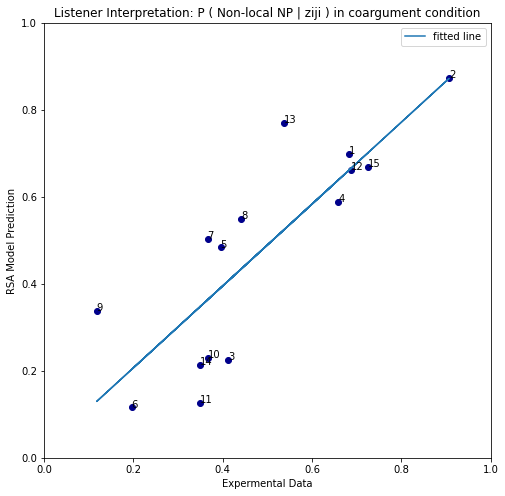

x: mean=0.479 stdv=0.208
y: mean=0.470 stdv=0.238
Statistics: LinregressResult(slope=0.9408976606586079, intercept=0.01894932380159059, rvalue=0.82146404739738, pvalue=0.00017293997708639375, stderr=0.18115707348934978, intercept_stderr=0.09462286291227578)
R-squared: 0.674803
Pearsons correlation: 0.821
covariance is:  [[0.04621612 0.04348464]
 [0.04348464 0.0606319 ]]
pval = 0.00017293997708639375, reject null hypothesis
coargument ziji Local NP


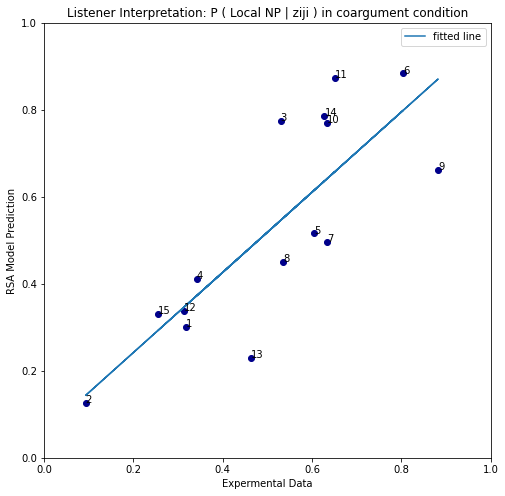

x: mean=0.512 stdv=0.207
y: mean=0.530 stdv=0.238
Statistics: LinregressResult(slope=0.9214869793963549, intercept=0.05793652713830183, rvalue=0.8031457927703396, pvalue=0.0003112762056958451, stderr=0.189588028394392, intercept_stderr=0.10479855234707856)
R-squared: 0.645043
Pearsons correlation: 0.803
covariance is:  [[0.04605869 0.04244248]
 [0.04244248 0.0606319 ]]
pval = 0.0003112762056958451, reject null hypothesis
coargument ziji Others
[coargument,ziji,Others] combination does not exist
possessor ta Non-local NP


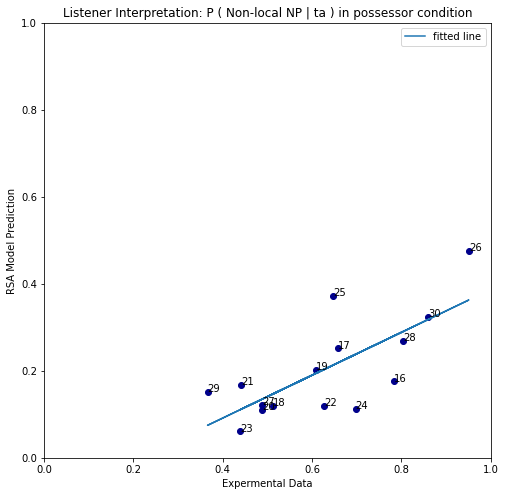

x: mean=0.625 stdv=0.166
y: mean=0.202 stdv=0.112
Statistics: LinregressResult(slope=0.49247794703054976, intercept=-0.10558006099080855, rvalue=0.7306855594432075, pvalue=0.001973957577163666, stderr=0.1276213964774033, intercept_stderr=0.08250428551462304)
R-squared: 0.533901
Pearsons correlation: 0.731
covariance is:  [[0.02943404 0.01449561]
 [0.01449561 0.01337095]]
pval = 0.001973957577163666, reject null hypothesis
possessor ta Local NP


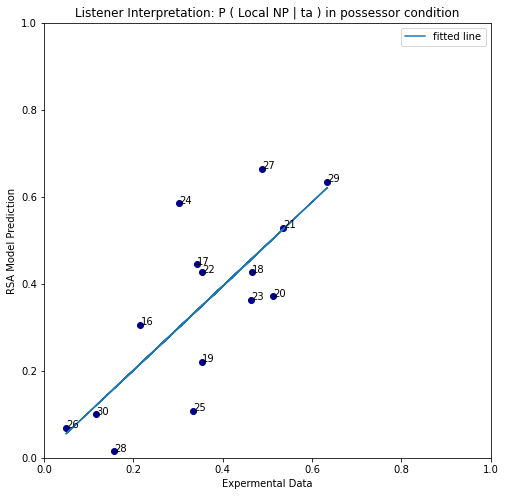

x: mean=0.355 stdv=0.161
y: mean=0.351 stdv=0.203
Statistics: LinregressResult(slope=0.9671282863173534, intercept=0.007937938201247219, rvalue=0.7668463005259194, pvalue=0.000850826882128444, stderr=0.22450427946108728, intercept_stderr=0.08744051217845819)
R-squared: 0.588053
Pearsons correlation: 0.767
covariance is:  [[0.02782261 0.02690803]
 [0.02690803 0.04425367]]
pval = 0.000850826882128444, reject null hypothesis
possessor ta Others


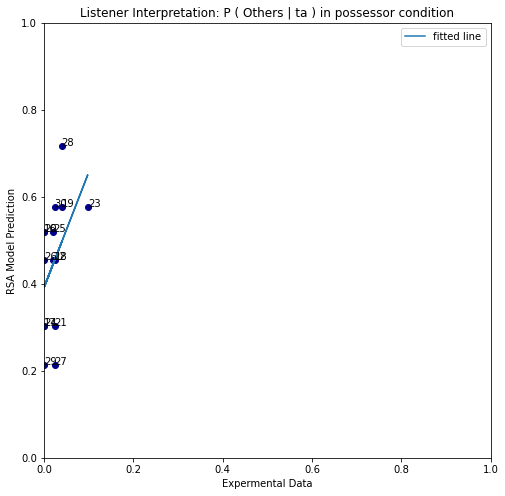

x: mean=0.021 stdv=0.025
y: mean=0.447 stdv=0.144
Statistics: LinregressResult(slope=2.6453244744885818, intercept=0.39262303611287247, rvalue=0.4554800889451006, pvalue=0.08797747370906026, stderr=1.4339958479762074, intercept_stderr=0.04613538638800706)
R-squared: 0.207462
Pearsons correlation: 0.455
covariance is:  [[0.0006566  0.00173692]
 [0.00173692 0.02214722]]
pval = 0.08797747370906026, accept null hypothesis
possessor taziji Non-local NP


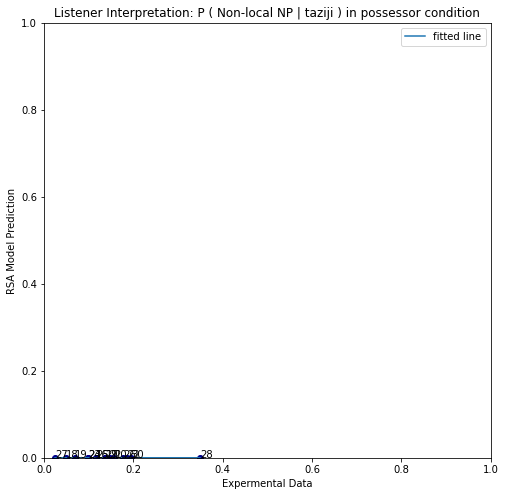

x: mean=0.137 stdv=0.074
y: mean=0.000 stdv=0.000
Statistics: LinregressResult(slope=0.0, intercept=0.0, rvalue=0.0, pvalue=1.0, stderr=0.0, intercept_stderr=0.0)
R-squared: 0.000000
Pearsons correlation: nan
covariance is:  [[0.00582961 0.        ]
 [0.         0.        ]]
pval = 1.0, accept null hypothesis
possessor taziji Local NP


/Users/lisazhao/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


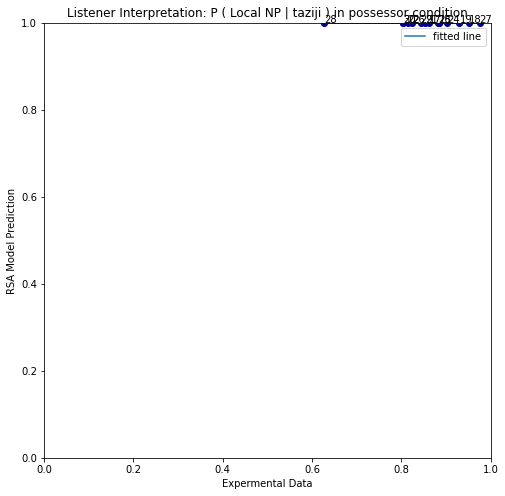

x: mean=0.856 stdv=0.079
y: mean=1.000 stdv=0.000
Statistics: LinregressResult(slope=0.0, intercept=1.0, rvalue=0.0, pvalue=1.0, stderr=0.0, intercept_stderr=0.0)
R-squared: 0.000000
Pearsons correlation: nan
covariance is:  [[0.00669013 0.        ]
 [0.         0.        ]]
pval = 1.0, accept null hypothesis
possessor taziji Others
[possessor,taziji,Others] combination does not exist
possessor ziji Non-local NP


/Users/lisazhao/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


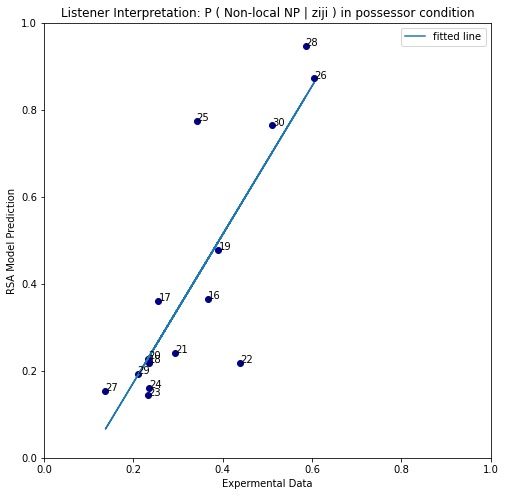

x: mean=0.338 stdv=0.138
y: mean=0.408 stdv=0.277
Statistics: LinregressResult(slope=1.7041524576734723, intercept=-0.1677054700342243, rvalue=0.8466995252431018, pvalue=6.849510098626557e-05, stderr=0.2970142741519878, intercept_stderr=0.1083761821873853)
R-squared: 0.716900
Pearsons correlation: 0.847
covariance is:  [[0.0203148  0.03461952]
 [0.03461952 0.0822945 ]]
pval = 6.849510098626557e-05, reject null hypothesis
possessor ziji Local NP


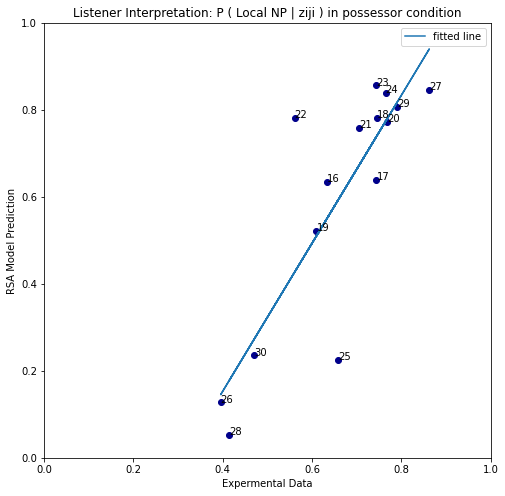

x: mean=0.658 stdv=0.137
y: mean=0.592 stdv=0.277
Statistics: LinregressResult(slope=1.70077821031202, intercept=-0.5271295765929398, rvalue=0.843337762974933, pvalue=7.819674196377926e-05, stderr=0.3005793087786828, intercept_stderr=0.2020275255971006)
R-squared: 0.711219
Pearsons correlation: 0.843
covariance is:  [[0.02023385 0.03441329]
 [0.03441329 0.0822945 ]]
pval = 7.819674196377926e-05, reject null hypothesis
possessor ziji Others
[possessor,ziji,Others] combination does not exist


In [135]:

c1 = ['coargument','possessor'] #one for each condition
c2 = ['Non-local NP', 'Local NP','Others']
c3 = ['ta', 'taziji', 'ziji']

for i in c1:
    if i == 'possessor':
        P_ziji = 187517/263039
        P_taziji = 695/263039
        P_ta = 74827/263039
        
        Pairs = {'ziji': ['Non-local NP', 'Local NP'],'taziji': ['Local NP'],'ta': ['Non-local NP', 'Local NP', 'Others']}
        #Pairs = {'ziji': ['Speaker', 'Clause Subject'],'taziji': ['Clause Subject'],'ta': ['Speaker', 'Clause Subject']}
    
    else:
        P_ziji = 309053/1046136
        P_taziji = 1503/1046136
        P_ta = 735580/1046136
        Pairs = {'ziji': ['Non-local NP', 'Local NP'],'taziji': ['Local NP'],'ta': ['Non-local NP','Others']}
    
    for m in M:
        for w in c2:
            print(i,m,w)
            try:
                #print("i=",i,'P_ziji:', P_ziji)
                estimatePosterior(i,w,m)
            except:
                print('[{},{},{}] combination does not exist'.format(i,m,w))
            

coargument ta Non-local NP


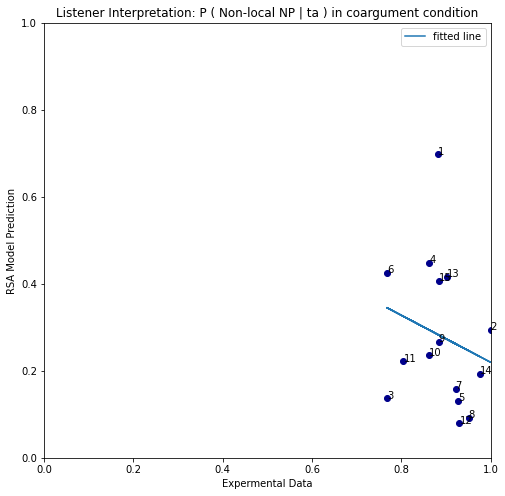

x: mean=0.888 stdv=0.066
y: mean=0.280 stdv=0.164
Statistics: LinregressResult(slope=-0.540431644495815, intercept=0.7601009385224953, rvalue=-0.21822227215696566, pvalue=0.4346044151733789, stderr=0.6703088227329376, intercept_stderr=0.597006330538197)
R-squared: 0.047621
Pearsons correlation: -0.218
covariance is:  [[ 0.00472505 -0.00255357]
 [-0.00255357  0.02897945]]
pval = 0.4346044151733789, accept null hypothesis
coargument ta Local NP


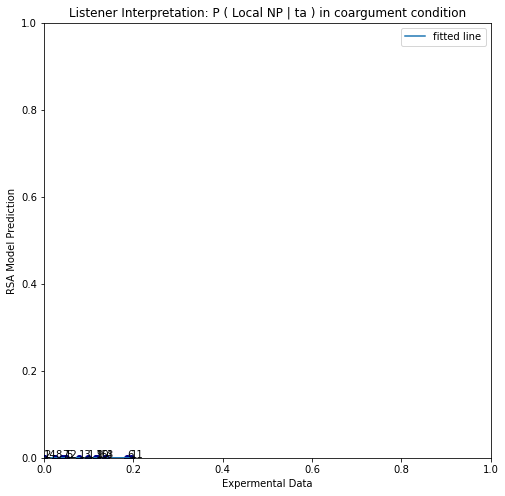

x: mean=0.090 stdv=0.060
y: mean=0.000 stdv=0.000
Statistics: LinregressResult(slope=0.0, intercept=0.0, rvalue=0.0, pvalue=1.0, stderr=0.0, intercept_stderr=0.0)
R-squared: 0.000000
Pearsons correlation: nan
covariance is:  [[0.00385553 0.        ]
 [0.         0.        ]]
pval = 1.0, accept null hypothesis
coargument ta Others


/Users/lisazhao/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


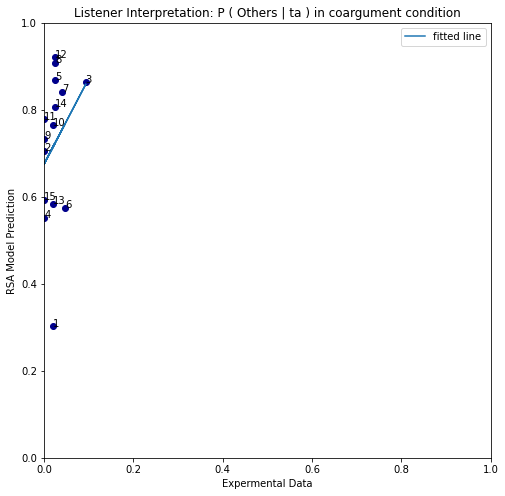

x: mean=0.022 stdv=0.024
y: mean=0.720 stdv=0.164
Statistics: LinregressResult(slope=1.9642170076893382, intercept=0.6761546047121711, rvalue=0.2825692368905317, pvalue=0.30752253264174395, stderr=1.8493679173902688, intercept_stderr=0.060084851078798324)
R-squared: 0.079845
Pearsons correlation: 0.283
covariance is:  [[0.00059974 0.00117801]
 [0.00117801 0.02897945]]
pval = 0.30752253264174395, accept null hypothesis
coargument taziji Non-local NP


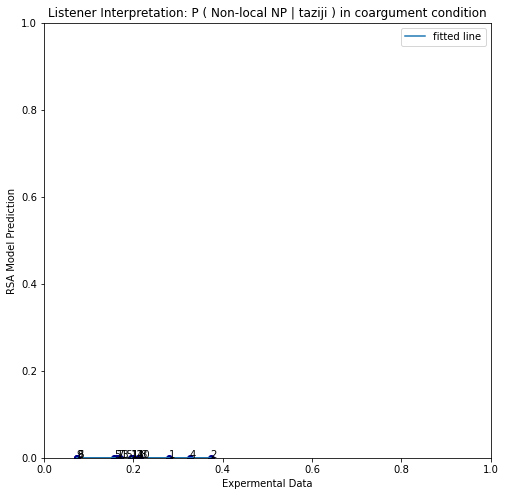

x: mean=0.191 stdv=0.084
y: mean=0.000 stdv=0.000
Statistics: LinregressResult(slope=0.0, intercept=0.0, rvalue=0.0, pvalue=1.0, stderr=0.0, intercept_stderr=0.0)
R-squared: 0.000000
Pearsons correlation: nan
covariance is:  [[0.0074757 0.       ]
 [0.        0.       ]]
pval = 1.0, accept null hypothesis
coargument taziji Local NP


/Users/lisazhao/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


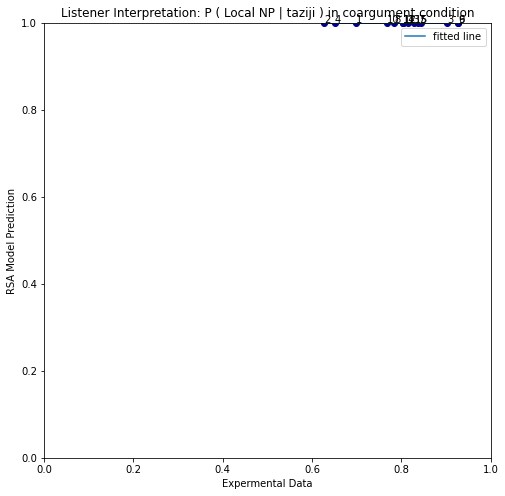

x: mean=0.801 stdv=0.086
y: mean=1.000 stdv=0.000
Statistics: LinregressResult(slope=0.0, intercept=1.0, rvalue=0.0, pvalue=1.0, stderr=0.0, intercept_stderr=0.0)
R-squared: 0.000000
Pearsons correlation: nan
covariance is:  [[0.00790648 0.        ]
 [0.         0.        ]]
pval = 1.0, accept null hypothesis
coargument taziji Others
[coargument,taziji,Others] combination does not exist
coargument ziji Non-local NP


/Users/lisazhao/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


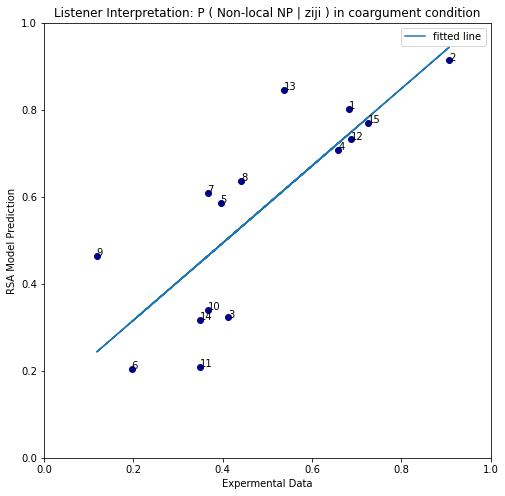

x: mean=0.479 stdv=0.208
y: mean=0.564 stdv=0.230
Statistics: LinregressResult(slope=0.8873473612800046, intercept=0.13902784225688458, rvalue=0.8016040985312392, pvalue=0.0003261652190624741, stderr=0.18355156240971549, intercept_stderr=0.09587356426493396)
R-squared: 0.642569
Pearsons correlation: 0.802
covariance is:  [[0.04621612 0.04100976]
 [0.04100976 0.05663188]]
pval = 0.0003261652190624741, reject null hypothesis
coargument ziji Local NP


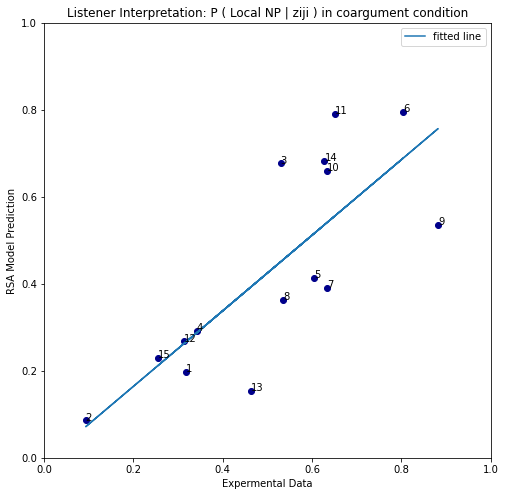

x: mean=0.512 stdv=0.207
y: mean=0.436 stdv=0.230
Statistics: LinregressResult(slope=0.868345168216109, intercept=-0.009247055347529232, rvalue=0.7831008091244216, pvalue=0.000555005767638885, stderr=0.19125815312150996, intercept_stderr=0.10572174699772875)
R-squared: 0.613247
Pearsons correlation: 0.783
covariance is:  [[0.04605869 0.03999484]
 [0.03999484 0.05663188]]
pval = 0.000555005767638885, reject null hypothesis
coargument ziji Others
[coargument,ziji,Others] combination does not exist
possessor ta Non-local NP


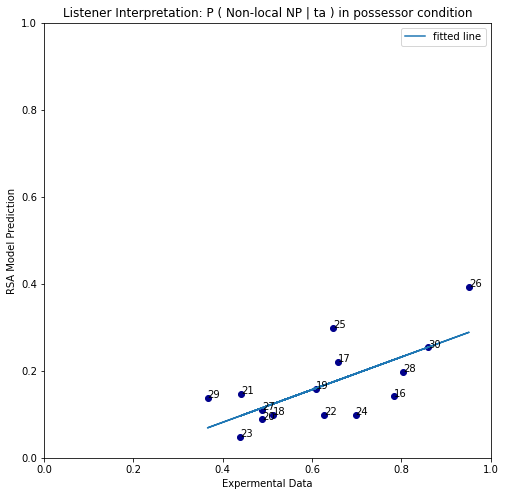

x: mean=0.625 stdv=0.166
y: mean=0.166 stdv=0.089
Statistics: LinregressResult(slope=0.3752438969576188, intercept=-0.06841799515370567, rvalue=0.6965894662103338, pvalue=0.003909401670852527, stderr=0.10719357837673588, intercept_stderr=0.06929817287569211)
R-squared: 0.485237
Pearsons correlation: 0.697
covariance is:  [[0.02943404 0.01104494]
 [0.01104494 0.00854129]]
pval = 0.003909401670852527, reject null hypothesis
possessor ta Local NP


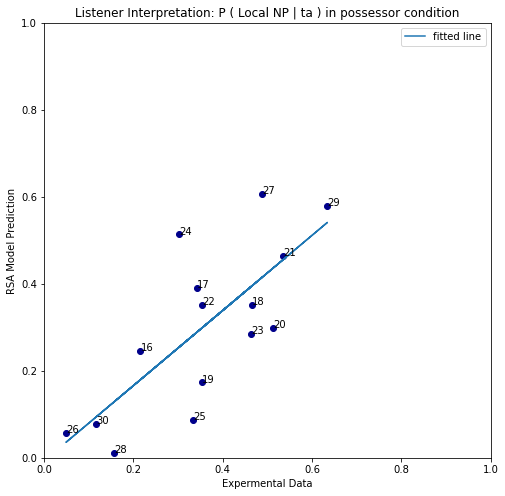

x: mean=0.355 stdv=0.161
y: mean=0.300 stdv=0.185
Statistics: LinregressResult(slope=0.8634721520374953, intercept=-0.00653942254557216, rvalue=0.7515702645840066, pvalue=0.0012346081208439777, stderr=0.21019512562761794, intercept_stderr=0.08186734563106605)
R-squared: 0.564858
Pearsons correlation: 0.752
covariance is:  [[0.02782261 0.02402405]
 [0.02402405 0.03672445]]
pval = 0.0012346081208439777, reject null hypothesis
possessor ta Others


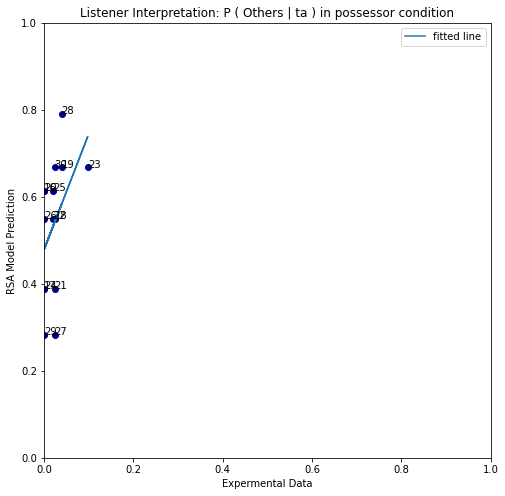

x: mean=0.021 stdv=0.025
y: mean=0.534 stdv=0.148
Statistics: LinregressResult(slope=2.6562060819930493, intercept=0.4797252692182933, rvalue=0.4435239367288523, pvalue=0.09772883403683444, stderr=1.4887036942956098, intercept_stderr=0.047895480485882866)
R-squared: 0.196713
Pearsons correlation: 0.444
covariance is:  [[0.0006566  0.00174406]
 [0.00174406 0.02354992]]
pval = 0.09772883403683444, accept null hypothesis
possessor taziji Non-local NP


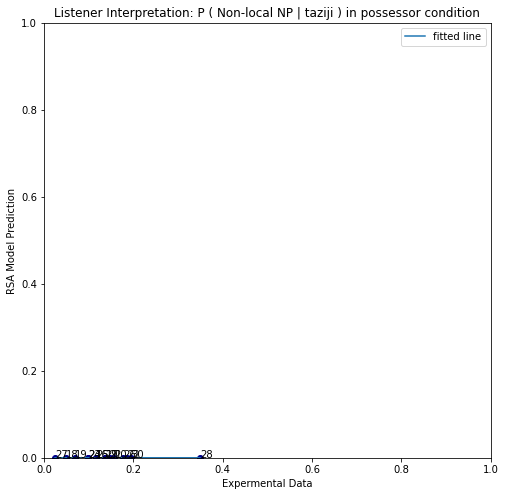

x: mean=0.137 stdv=0.074
y: mean=0.000 stdv=0.000
Statistics: LinregressResult(slope=0.0, intercept=0.0, rvalue=0.0, pvalue=1.0, stderr=0.0, intercept_stderr=0.0)
R-squared: 0.000000
Pearsons correlation: nan
covariance is:  [[0.00582961 0.        ]
 [0.         0.        ]]
pval = 1.0, accept null hypothesis
possessor taziji Local NP


/Users/lisazhao/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


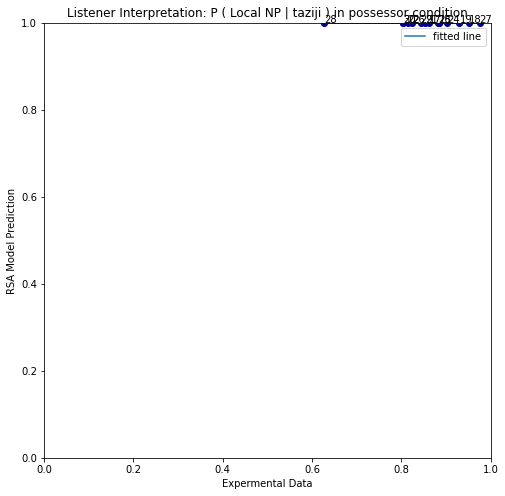

x: mean=0.856 stdv=0.079
y: mean=1.000 stdv=0.000
Statistics: LinregressResult(slope=0.0, intercept=1.0, rvalue=0.0, pvalue=1.0, stderr=0.0, intercept_stderr=0.0)
R-squared: 0.000000
Pearsons correlation: nan
covariance is:  [[0.00669013 0.        ]
 [0.         0.        ]]
pval = 1.0, accept null hypothesis
possessor taziji Others
[possessor,taziji,Others] combination does not exist
possessor ziji Non-local NP


/Users/lisazhao/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


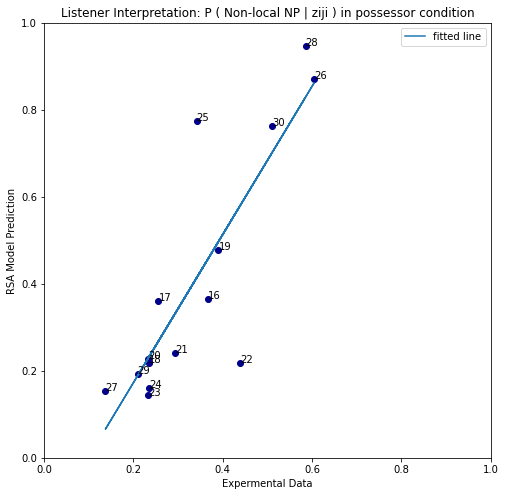

x: mean=0.338 stdv=0.138
y: mean=0.408 stdv=0.277
Statistics: LinregressResult(slope=1.7029265721459772, intercept=-0.1676134913937492, rvalue=0.8467016668165686, pvalue=6.84892537003049e-05, stderr=0.29679796460310326, intercept_stderr=0.10829725398386474)
R-squared: 0.716904
Pearsons correlation: 0.847
covariance is:  [[0.0203148  0.03459461]
 [0.03459461 0.08217573]]
pval = 6.84892537003049e-05, reject null hypothesis
possessor ziji Local NP


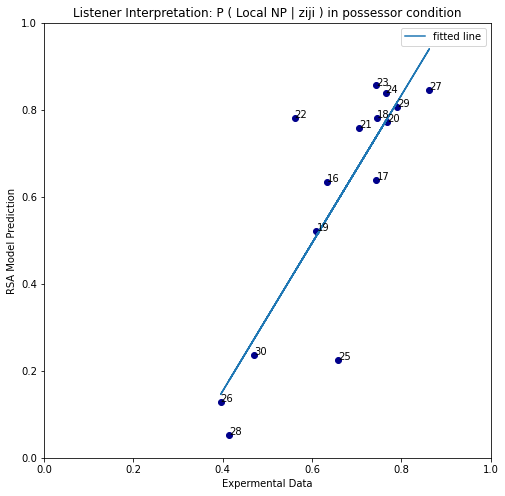

x: mean=0.658 stdv=0.137
y: mean=0.592 stdv=0.277
Statistics: LinregressResult(slope=1.6995527146497271, intercept=-0.5260010317364832, rvalue=0.8433388850593646, pvalue=7.819332439982282e-05, stderr=0.30036134248346175, intercept_stderr=0.2018810245240028)
R-squared: 0.711220
Pearsons correlation: 0.843
covariance is:  [[0.02023385 0.0343885 ]
 [0.0343885  0.08217573]]
pval = 7.819332439982282e-05, reject null hypothesis
possessor ziji Others
[possessor,ziji,Others] combination does not exist


In [134]:

# c1 = ['coargument','possessor'] #one for each condition
# c2 = ['Non-local NP', 'Local NP','Others']
# c3 = ['ta', 'taziji', 'ziji']

# for i in c1:
#     if i == 'possessor':
# #         P_ziji = 187517/263039
# #         P_taziji = 695/263039
# #         P_ta = 74827/263039

#         P_ziji = 187517/232154
#         P_taziji = 478/232154
#         P_ta = 44159/232154
        
#         Pairs = {'ziji': ['Non-local NP', 'Local NP'],'taziji': ['Local NP'],'ta': ['Non-local NP', 'Local NP', 'Others']}
#         #Pairs = {'ziji': ['Speaker', 'Clause Subject'],'taziji': ['Clause Subject'],'ta': ['Speaker', 'Clause Subject']}
    
#     else:
# #         P_ziji = 309053/1046136
# #         P_taziji = 1503/1046136
# #         P_ta = 735580/1046136
#         P_ziji = 309053/557579
#         P_taziji = 980/557579
#         P_ta = 247546/557579
#         Pairs = {'ziji': ['Non-local NP', 'Local NP'],'taziji': ['Local NP'],'ta': ['Non-local NP','Others']}
    
#     for m in M:
#         for w in c2:
#             print(i,m,w)
#             try:
#                 #print("i=",i,'P_ziji:', P_ziji)
#                 estimatePosterior(i,w,m)
#             except:
#                 print('[{},{},{}] combination does not exist'.format(i,m,w))
            

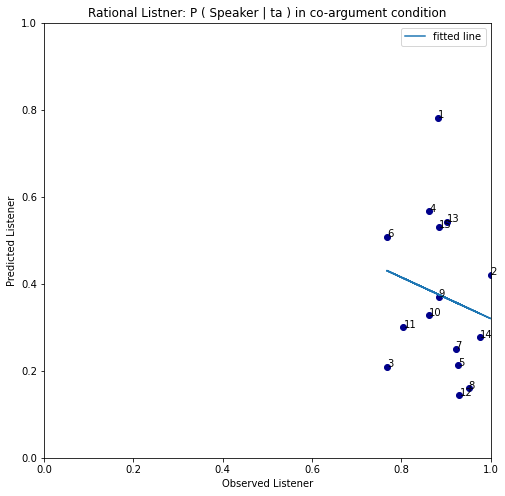

Statistics: LinregressResult(slope=-0.4746369892856643, intercept=0.7948195354138967, rvalue=-0.17988310124925996, pvalue=0.5211911763883716, stderr=0.7198746972862284, intercept_stderr=0.6411518644822822)
R-squared: 0.032358
pval = 0.5211911763883716, accept null hypothesis


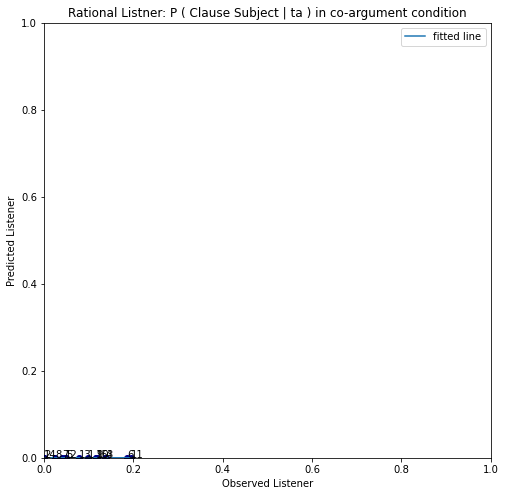

Statistics: LinregressResult(slope=0.0, intercept=0.0, rvalue=0.0, pvalue=1.0, stderr=0.0, intercept_stderr=0.0)
R-squared: 0.000000
pval = 1.0, accept null hypothesis


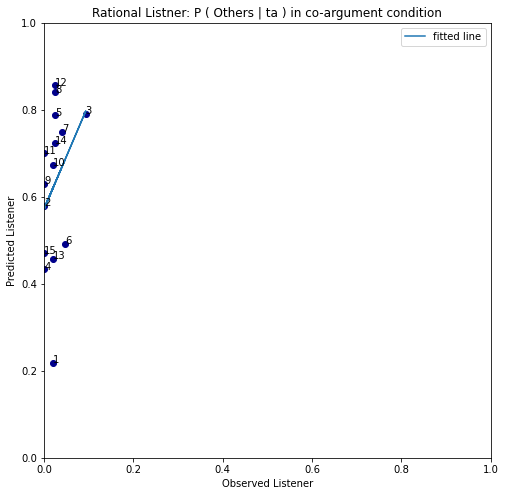

Statistics: LinregressResult(slope=2.408801734401483, intercept=0.5731000927459052, rvalue=0.325242244934729, pvalue=0.23685563511481347, stderr=1.942423873142614, intercept_stderr=0.06310818309986257)
R-squared: 0.105783
pval = 0.23685563511481347, accept null hypothesis


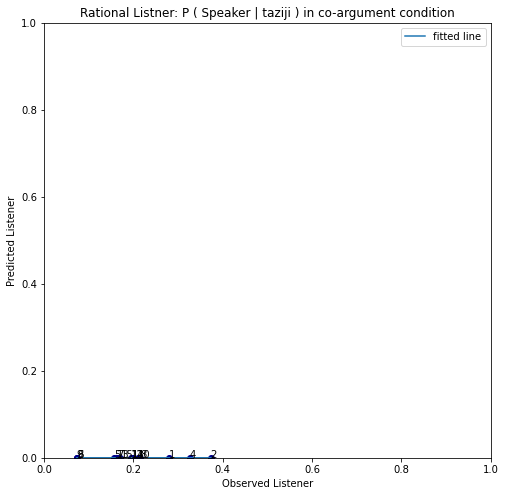

Statistics: LinregressResult(slope=0.0, intercept=0.0, rvalue=0.0, pvalue=1.0, stderr=0.0, intercept_stderr=0.0)
R-squared: 0.000000
pval = 1.0, accept null hypothesis


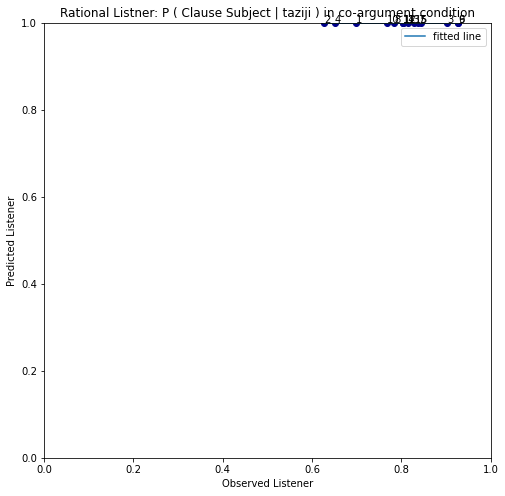

Statistics: LinregressResult(slope=0.0, intercept=1.0, rvalue=0.0, pvalue=1.0, stderr=0.0, intercept_stderr=0.0)
R-squared: 0.000000
pval = 1.0, accept null hypothesis
[co-argument,Others,taziji] combination does not exist


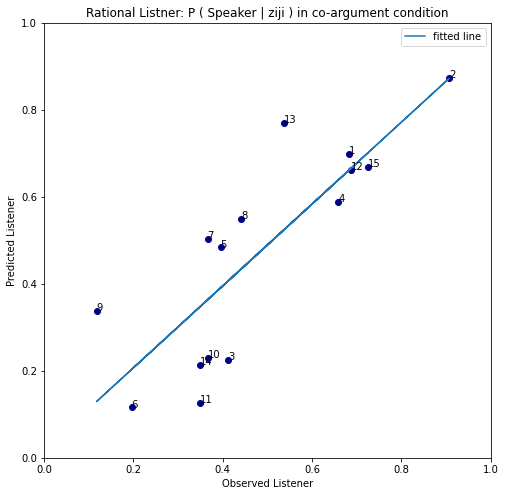

Statistics: LinregressResult(slope=0.9408976606586079, intercept=0.01894932380159059, rvalue=0.82146404739738, pvalue=0.00017293997708639375, stderr=0.18115707348934978, intercept_stderr=0.09462286291227578)
R-squared: 0.674803
pval = 0.00017293997708639375, reject null hypothesis


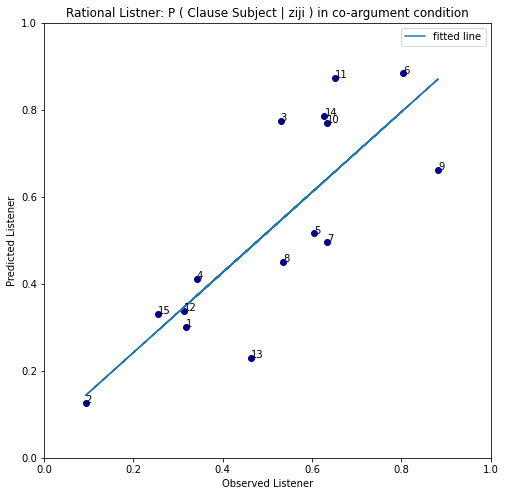

Statistics: LinregressResult(slope=0.9214869793963549, intercept=0.05793652713830183, rvalue=0.8031457927703396, pvalue=0.0003112762056958451, stderr=0.189588028394392, intercept_stderr=0.10479855234707856)
R-squared: 0.645043
pval = 0.0003112762056958451, reject null hypothesis
[co-argument,Others,ziji] combination does not exist


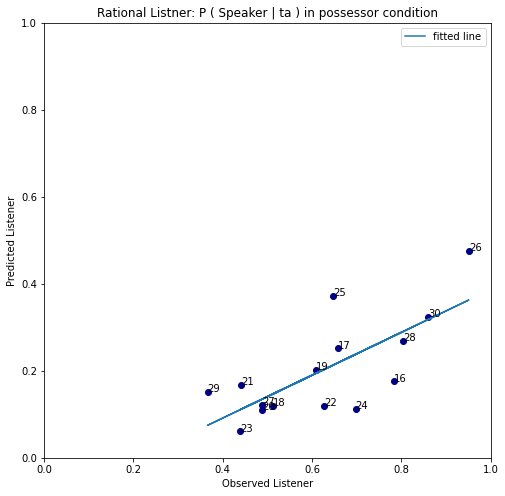

Statistics: LinregressResult(slope=0.49247794703054976, intercept=-0.10558006099080855, rvalue=0.7306855594432075, pvalue=0.001973957577163666, stderr=0.1276213964774033, intercept_stderr=0.08250428551462304)
R-squared: 0.533901
pval = 0.001973957577163666, reject null hypothesis


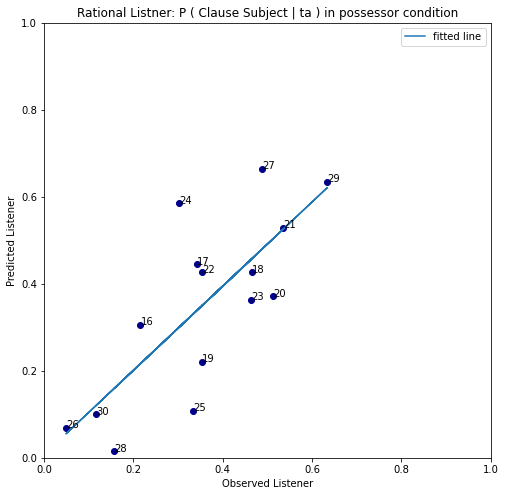

Statistics: LinregressResult(slope=0.9671282863173535, intercept=0.007937938201247163, rvalue=0.7668463005259194, pvalue=0.000850826882128444, stderr=0.22450427946108728, intercept_stderr=0.08744051217845819)
R-squared: 0.588053
pval = 0.000850826882128444, reject null hypothesis


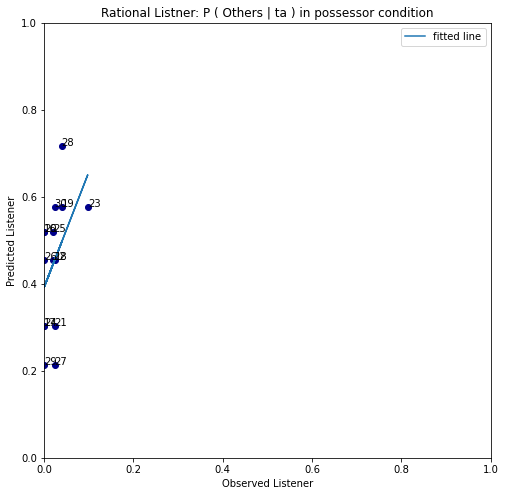

Statistics: LinregressResult(slope=2.6453244744885818, intercept=0.39262303611287236, rvalue=0.4554800889451006, pvalue=0.08797747370906026, stderr=1.4339958479762076, intercept_stderr=0.046135386388007064)
R-squared: 0.207462
pval = 0.08797747370906026, accept null hypothesis


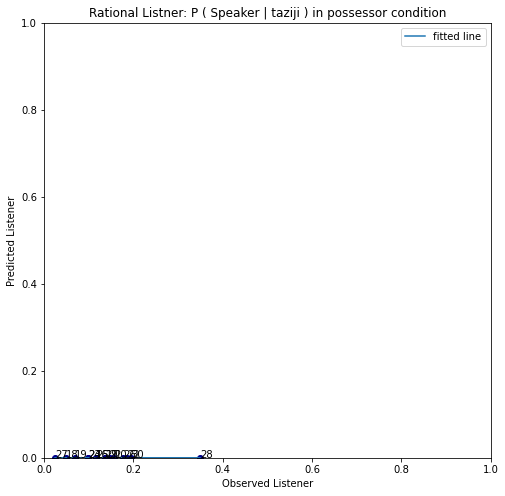

Statistics: LinregressResult(slope=0.0, intercept=0.0, rvalue=0.0, pvalue=1.0, stderr=0.0, intercept_stderr=0.0)
R-squared: 0.000000
pval = 1.0, accept null hypothesis


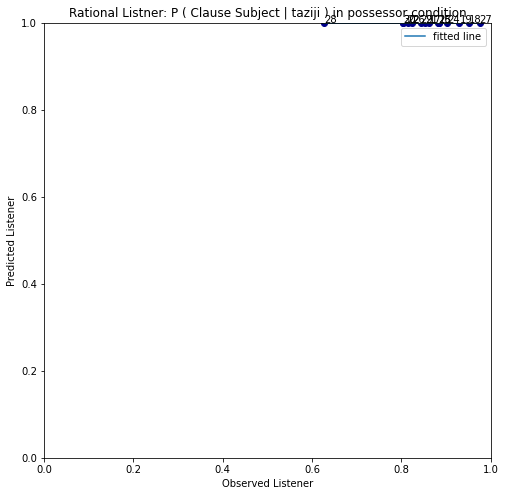

Statistics: LinregressResult(slope=0.0, intercept=1.0, rvalue=0.0, pvalue=1.0, stderr=0.0, intercept_stderr=0.0)
R-squared: 0.000000
pval = 1.0, accept null hypothesis
[possessor,Others,taziji] combination does not exist


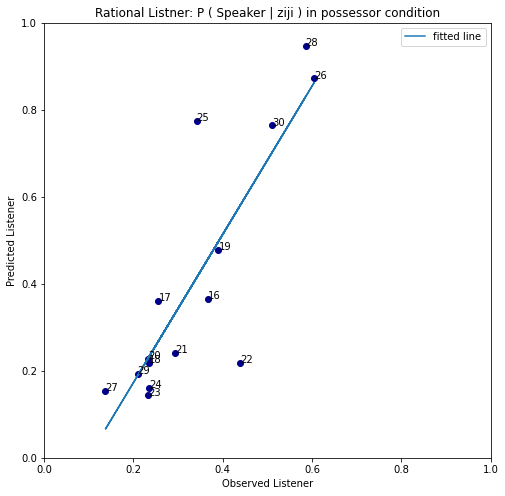

Statistics: LinregressResult(slope=1.7041524576734723, intercept=-0.16770547003422442, rvalue=0.8466995252431019, pvalue=6.849510098626533e-05, stderr=0.2970142741519876, intercept_stderr=0.10837618218738523)
R-squared: 0.716900
pval = 6.849510098626533e-05, reject null hypothesis


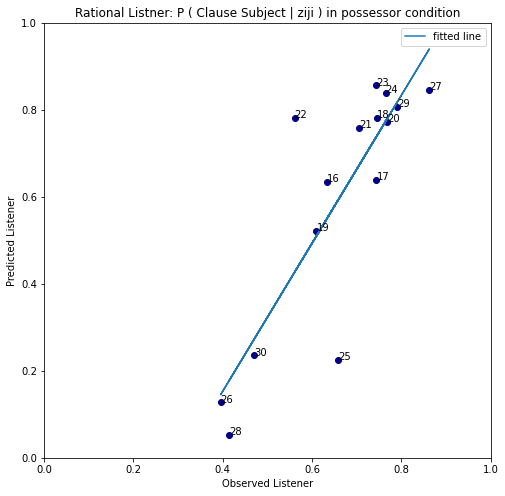

Statistics: LinregressResult(slope=1.70077821031202, intercept=-0.5271295765929398, rvalue=0.8433377629749328, pvalue=7.819674196377984e-05, stderr=0.300579308778683, intercept_stderr=0.20202752559710074)
R-squared: 0.711219
pval = 7.819674196377984e-05, reject null hypothesis
[possessor,Others,ziji] combination does not exist


In [57]:
c1 = ['co-argument','possessor']
c2 = ['Speaker', 'Clause Subject','Others']
c3 = ['ta', 'taziji', 'ziji']

for i in c1:
    if i == 'co-argument':
        P_ziji = 309053/1046136
        P_taziji = 1503/1046136
        P_ta = 735580/1046136
    else:
        P_ziji = 187517/263039
        P_taziji = 695/263039
        P_ta = 74827/263039
        
        
    for k in c3:
        for j in c2:
            try:
                #print("i=",i,'P_ziji:', P_ziji)
                estimatePosterior(i,j,k)
            except:
                print('[{},{},{}] combination does not exist'.format(i,j,k))
                

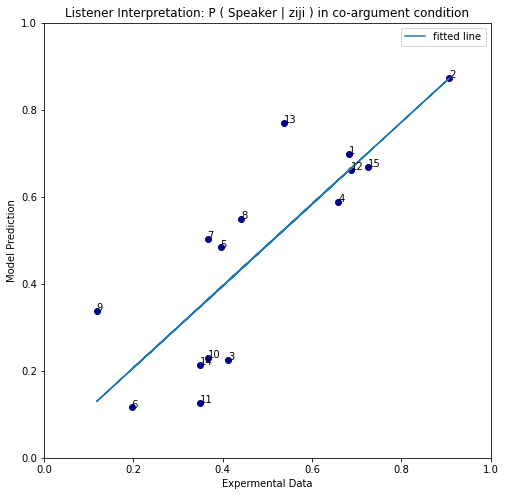

Statistics: LinregressResult(slope=0.9408976606586079, intercept=0.01894932380159059, rvalue=0.82146404739738, pvalue=0.00017293997708639375, stderr=0.18115707348934978, intercept_stderr=0.09462286291227578)
R-squared: 0.674803
pval = 0.00017293997708639375, reject null hypothesis


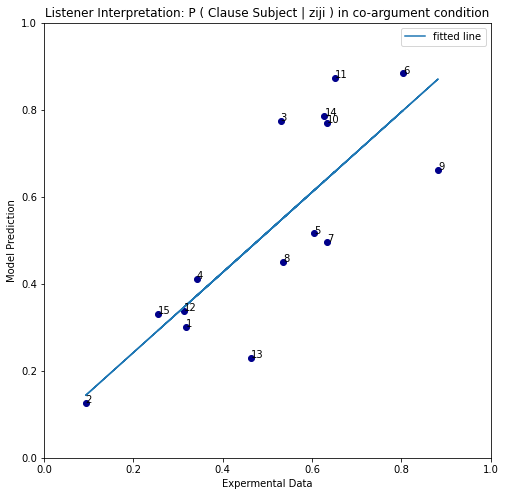

Statistics: LinregressResult(slope=0.9214869793963549, intercept=0.05793652713830183, rvalue=0.8031457927703396, pvalue=0.0003112762056958451, stderr=0.189588028394392, intercept_stderr=0.10479855234707856)
R-squared: 0.645043
pval = 0.0003112762056958451, reject null hypothesis


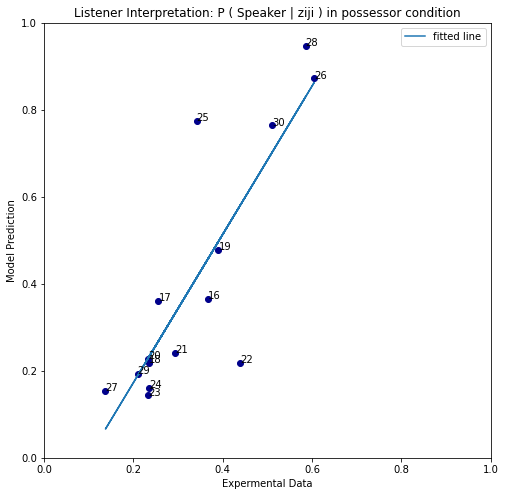

Statistics: LinregressResult(slope=1.7041524576734723, intercept=-0.16770547003422442, rvalue=0.8466995252431019, pvalue=6.849510098626533e-05, stderr=0.2970142741519876, intercept_stderr=0.10837618218738523)
R-squared: 0.716900
pval = 6.849510098626533e-05, reject null hypothesis


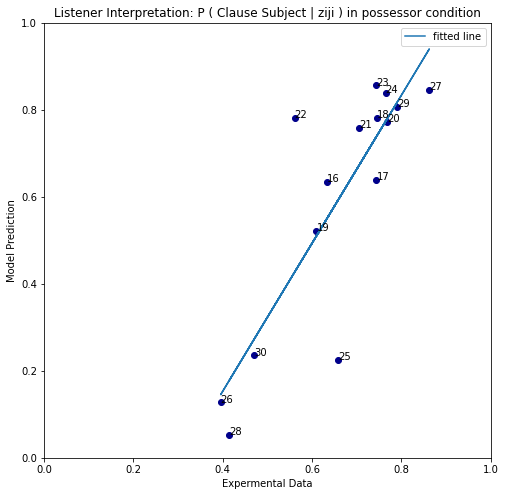

Statistics: LinregressResult(slope=1.70077821031202, intercept=-0.5271295765929398, rvalue=0.8433377629749328, pvalue=7.819674196377984e-05, stderr=0.300579308778683, intercept_stderr=0.20202752559710074)
R-squared: 0.711219
pval = 7.819674196377984e-05, reject null hypothesis


In [14]:
for i in c1:
    if i == 'co-argument':
        P_ziji = 309053/1046136
        P_taziji = 1503/1046136
        P_ta = 735580/1046136
    else:
        P_ziji = 187517/263039
        P_taziji = 695/263039
        P_ta = 74827/263039
        
    k='ziji'
    for j in c2:
        try:
            #print("i=",i,'P_ziji:', P_ziji)
            estimatePosterior(i,j,k)
        except:
            print('[{},{},{}] combination does not exist'.format(i,j,k))
                

i= co-argument P_ziji: 0.2954233483982962


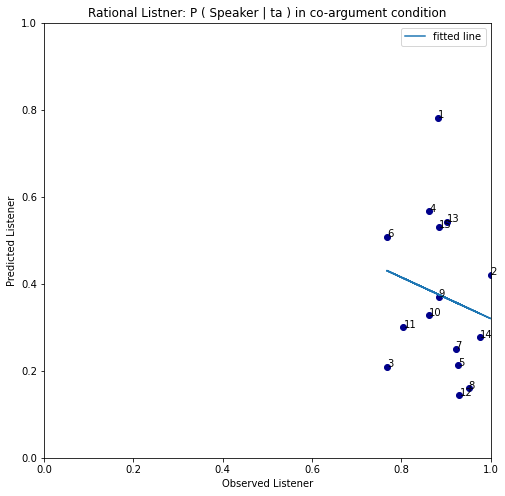

Statistics: LinregressResult(slope=-0.4746369892856643, intercept=0.7948195354138967, rvalue=-0.17988310124925996, pvalue=0.5211911763883716, stderr=0.7198746972862284, intercept_stderr=0.6411518644822822)
R-squared: 0.032358
pval = 0.5211911763883716, accept null hypothesis
i= co-argument P_ziji: 0.2954233483982962


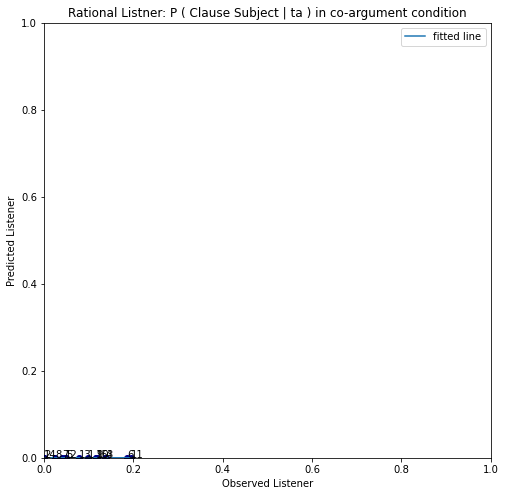

Statistics: LinregressResult(slope=0.0, intercept=0.0, rvalue=0.0, pvalue=1.0, stderr=0.0, intercept_stderr=0.0)
R-squared: 0.000000
pval = 1.0, accept null hypothesis
i= possessor P_ziji: 0.7128866822030193


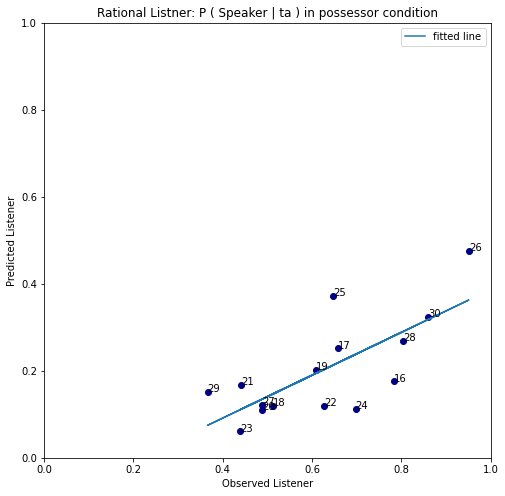

Statistics: LinregressResult(slope=0.49247794703054976, intercept=-0.10558006099080855, rvalue=0.7306855594432075, pvalue=0.001973957577163666, stderr=0.1276213964774033, intercept_stderr=0.08250428551462304)
R-squared: 0.533901
pval = 0.001973957577163666, reject null hypothesis
i= possessor P_ziji: 0.7128866822030193


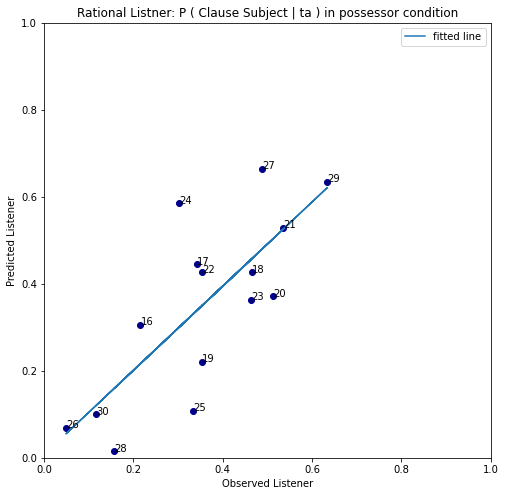

Statistics: LinregressResult(slope=0.9671282863173535, intercept=0.007937938201247163, rvalue=0.7668463005259194, pvalue=0.000850826882128444, stderr=0.22450427946108728, intercept_stderr=0.08744051217845819)
R-squared: 0.588053
pval = 0.000850826882128444, reject null hypothesis


In [16]:
for i in c1:
    if i == 'co-argument':
        P_ziji = 309053/1046136
        P_taziji = 1503/1046136
        P_ta = 735580/1046136
    else:
        P_ziji = 187517/263039
        P_taziji = 695/263039
        P_ta = 74827/263039
        
    k='ta'
    for j in c2:
        try:
            print("i=",i,'P_ziji:', P_ziji)
            estimatePosterior(i,j,k)
        except:
            print('[{},{},{}] combination does not exist'.format(i,j,k))
                

In [109]:
# corpus study improve the ta condition
# c1 = ['co-argument','possessor']
# c2 = ['Speaker', 'Clause Subject','Others']
# c3 = ['ta', 'taziji', 'ziji']
# P_ziji = 309053/1046136
# P_taziji = 1503/1046136
# P_ta = 735580/1046136

# for i in c1:
#     for k in c3:
#         for j in c2:
#             try:
#                 print("i=",i,'P_ziji:', P_ziji)
#                 estimatePosterior(i,j,k)
#             except:
#                 print('[{},{},{}] combination does not exist'.format(i,j,k))
                